# Environment

## Libraries

In [1]:
import os, subprocess, json, requests, getpass, urllib.parse, google.cloud.bigquery as bigquery, sys, pathlib, \
seaborn as sns, pandas as pd, matplotlib.pyplot as plt
from bs4 import BeautifulSoup

## Specifying the Working Directory

In [2]:
workingdir=os.getcwd()
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])

    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

## Specifying GCP-Related Variables 

In [3]:
os.environ['PROJECT_ID'] = subprocess.run('gcloud config list project --format "value(core.project)"', 
                                          shell=True, check=True, stdout=subprocess.PIPE) \
                                            .stdout.decode().replace('\n', '').replace('\r', '')
print(os.environ['PROJECT_ID'])

axa-ch-machine-learning-dev


In [4]:
os.environ['BUCKET_NAME']='axa-ch-machine-learning-poc-dev'

In [5]:
try:
    tmp=os.environ['PROJECT_ID']
except:
    print('Env variable PROJECT not defined!') 

try:
    tmp=os.environ['BUCKET_NAME']
except:
    print('Env variable BUCKET_NAME not defined!') 
    
try:    
    tmp=os.environ['GOOGLE_APPLICATION_CREDENTIALS']
except:
    print('Env variable GOOGLE_APPLICATION_CREDENTIALS not defined!') 

try:
    tmp=os.environ['REQUESTS_CA_BUNDLE']
except:
    print('Env variable REQUESTS_CA_BUNDLE not defined!') 

try:
    tmp=os.environ['AXA_CH_CA_BUNDLE']
except:
    print('Env variable AXA_CA_CA_BUNDLE not defined!') 

## Does the Connection Work?

In [6]:
use_proxy='Y'
proxies = {
    'https': os.environ['HTTPS_PROXY'],    
    'http': os.environ['HTTP_PROXY']
}  

In [7]:
list_url=['https://www.google.com',
          'http://www.google.com',
          'https://www.example.com',
          'http://www.example.com',
          'https://github.com/j0hannes/cutter-ng']

for url in list_url:
    print('')
    print('trying to access:'+url)
    try:
        if use_proxy=='N':
            r = requests.get(url)
        else:
            # SSL deactivated
            #r = requests.get(url,proxies=proxies,verify=False)
            r = requests.get(url,proxies=proxies,verify=True)
            
        if r.status_code == requests.codes.ok:
            print('=>OK',r.headers['content-type'])
        else:
            # 407 Proxy Authentication Required
            print ('=> ??', r.status_code)
    except Exception as inst:
        print('=>FAILED')
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args
        print(inst)


trying to access:https://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:http://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:https://www.example.com
=>OK text/html; charset=UTF-8

trying to access:http://www.example.com
=>OK text/html; charset=UTF-8

trying to access:https://github.com/j0hannes/cutter-ng
=>OK text/html; charset=utf-8


# Exploratory Data Analysis

In [8]:
client = bigquery.Client()

In [9]:
query = """SELECT
  *
FROM
  `axa-ch-machine-learning-dev.nlp_text_classification.stackoverflow_posts_questions_small`"""
df_small = client.query(query).to_dataframe()

In [10]:
df_small.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,22804521,how to push my github repo into openshift and ...,<p>i'm newbie to openshift and git.I've my rep...,NaN,2,1,None,2014-04-02 07:34:06.840000+00:00,NaN,2014-09-02 23:53:30.343000+00:00,NaT,None,NaN,None,3488259.0,None,1,0,gitgithubsftpopenshift,256
1,47530134,`Trace: TypeError: React.__spread is not a fun...,<p>I was seeing a warning about this when I wa...,NaN,1,15,None,2017-11-28 11:11:28.023000+00:00,NaN,2017-11-28 12:49:25.707000+00:00,2017-11-28 12:15:47.737000+00:00,None,4015856.0,None,4015856.0,None,1,0,reactjsreact-reduxbabel,256
2,35257755,Append mouseover event to img in a div with jQ...,<p>I am trying to append a mouseover event to ...,35257815.0,1,0,None,2016-02-07 19:04:45.170000+00:00,NaN,2016-02-07 20:30:15.287000+00:00,NaT,None,NaN,None,5448626.0,None,1,0,jquery,256
3,31909648,Connect on website with HttpWebRequest,<p>I tried to use HttpWebRequest to connect on...,NaN,0,3,None,2015-08-09 23:00:17.090000+00:00,NaN,2015-08-10 16:59:35.420000+00:00,2015-08-10 16:59:35.420000+00:00,None,5182869.0,None,5182869.0,None,1,0,c#httpwebrequestwebclientwebclient-download,256
4,50601033,HTTP outbound gateway - uri variable - encoding,"<p>I have a http outbound gateway, which requi...",NaN,0,6,None,2018-05-30 09:25:08.833000+00:00,NaN,2018-05-30 14:23:15.030000+00:00,2018-05-30 14:23:15.030000+00:00,None,2017299.0,None,2017299.0,None,1,0,springspring-integrationgatewayoutbound,256


## Number of Views

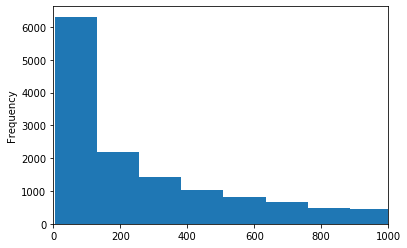

In [11]:
df_small['view_count'].plot(kind='hist', xlim=[0, 1000], bins=10000)

## Number of Answers

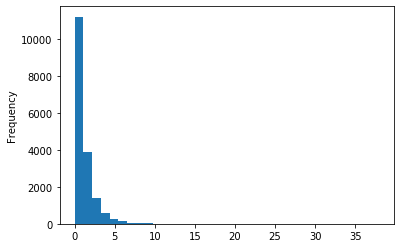

In [12]:
df_small['answer_count'].plot(kind='hist', bins=35)

## Answer-View Ratio

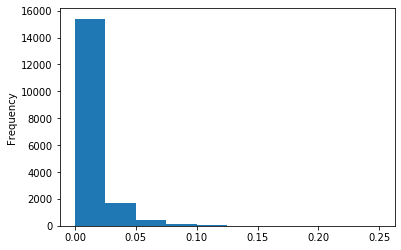

In [13]:
df_small['view_answer_ratio'] = df_small['answer_count']/df_small['view_count']
df_small['view_answer_ratio'].plot(kind='hist')

## Correlation: Views and Answers

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\pandas\plotting\_matplotlib\core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


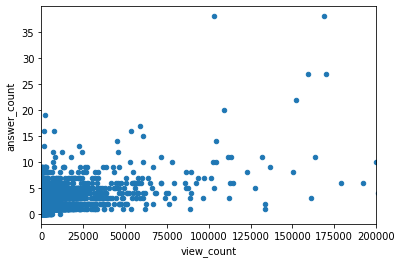

In [14]:
df_small.plot(x='view_count', y='answer_count', kind='scatter', xlim=[0, 200000])

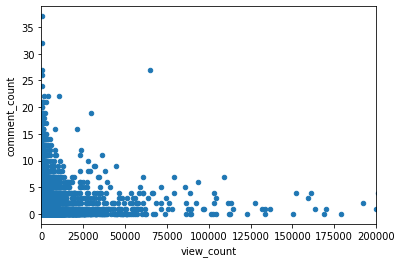

In [15]:
df_small.plot(x='view_count', y='comment_count', kind='scatter', xlim=[0, 200000])

In [16]:
#sns.pairplot(x_vars=["view_count"], y_vars=["answer_count"], data=df_small, hue="tags", size=5)

## Score

https://meta.stackexchange.com/questions/229255/what-is-the-score-of-a-post
number of upvotes - number of downvotes

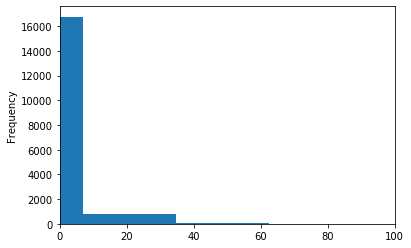

In [17]:
df_small['score'].plot(kind='hist', xlim=[0,100], bins=100)

## Creation Date

In [18]:
## Post Type

In [19]:
## Tags

In [20]:
##favorite count

# Suggest labels from the text

https://stackoverflow.com/help/tagging

In [21]:
query = """SELECT
  *
FROM
  `axa-ch-machine-learning-dev.nlp_text_classification.stackoverflow_posts_questions_small`
WHERE 
  tags = 'python'"""
df_small_python = client.query(query).to_dataframe()

In [22]:
df_small_python

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,4886634,python gtk window not responding,<p>I process a new function and append the val...,NaN,1,1,None,2011-02-03 13:21:59.563000+00:00,NaN,2011-02-03 13:30:52.560000+00:00,NaT,None,NaN,None,532065.0,None,1,0,python,258
1,53653262,Smoothing a Function with multiple Curves,"<p>I have a function that I wanted to graph, b...",NaN,2,1,None,2018-12-06 14:10:27.687000+00:00,NaN,2018-12-06 14:44:14.260000+00:00,NaT,None,NaN,None,10514313.0,None,1,0,python,23
2,33621250,"Python: If Statements, Raw_Input and List Gen",<p>I'm having a strange issue taking in user i...,NaN,2,1,None,2015-11-10 01:16:16.137000+00:00,NaN,2015-11-10 01:26:10.973000+00:00,2015-11-10 01:18:45.983000+00:00,None,5299236.0,None,5511425.0,None,1,0,python,24
3,55390009,A python code to summarize data of one column ...,<p>I am dealing with a data where I have two c...,NaN,0,3,None,2019-03-28 04:07:41.983000+00:00,NaN,2019-03-28 04:30:31.480000+00:00,NaT,None,NaN,None,10779961.0,None,1,0,python,26
4,55625816,ImportError: No module named ... (but I have _...,<p>I know this question is asked over and over...,NaN,1,4,None,2019-04-11 06:15:57.990000+00:00,NaN,2019-04-11 06:23:55.150000+00:00,2019-04-11 06:23:55.150000+00:00,None,455687.0,None,455687.0,None,1,0,python,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,30705276,Python - Position Argument missing,<p>My Python code has the following class</p>\...,30705335.0,1,0,None,2015-06-08 09:15:43.517000+00:00,NaN,2015-06-08 09:18:49.523000+00:00,2015-06-08 09:17:28.453000+00:00,None,100297.0,None,3503078.0,None,1,-2,python,40
67,42090662,Make condition true and pass it as argument,<p>I have a function where I am writing someth...,NaN,1,3,None,2017-02-07 13:06:15.660000+00:00,NaN,2017-02-10 02:57:20.500000+00:00,2017-02-10 02:57:20.500000+00:00,None,7311767.0,None,7358084.0,None,1,-1,python,37
68,53445767,Sorting .txt files,<p>I am trying to make the 'scores' section of...,53447162.0,3,3,None,2018-11-23 11:21:34.267000+00:00,0.0,2018-11-23 12:57:43.057000+00:00,2018-11-23 11:39:40.233000+00:00,None,10695208.0,None,10695208.0,None,1,-1,python,52
69,7239838,what is this saying in python,"<p><code>map(tuple, map(lambda row: [float(row...",7239900.0,2,0,None,2011-08-30 07:18:05.277000+00:00,NaN,2011-08-30 07:25:17.780000+00:00,NaT,None,NaN,None,382906.0,None,1,-1,python,84


## Word Cloud Body

In [23]:
questions_python = df_small_python[['body']].apply(lambda x: ' '.join(x), axis=0)[0]

In [24]:
soup = BeautifulSoup(questions_python, 'html.parser')

In [25]:
questions_python = soup.find_all('p')
questions_python_2 = ''

In [26]:
for qst in questions_python:
    questions_python_2 += qst.text

In [27]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [28]:
stopwords = set(STOPWORDS)

In [29]:
wordcloud = WordCloud(stopwords=stopwords).generate(questions_python_2)

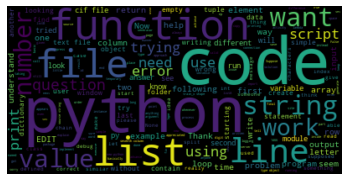

In [30]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud Title

In [31]:
title_python = df_small_python[['title']].apply(lambda x: ' '.join(x), axis=0)[0]

In [32]:
wordcloud_title = WordCloud(stopwords=stopwords).generate(title_python)

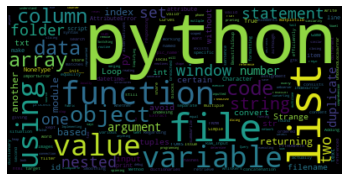

In [33]:
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
df_small.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,...,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count,view_answer_ratio
0,22804521,how to push my github repo into openshift and ...,<p>i'm newbie to openshift and git.I've my rep...,NaN,2,1,None,2014-04-02 07:34:06.840000+00:00,NaN,2014-09-02 23:53:30.343000+00:00,...,None,NaN,None,3488259.0,None,1,0,gitgithubsftpopenshift,256,0.007812
1,47530134,`Trace: TypeError: React.__spread is not a fun...,<p>I was seeing a warning about this when I wa...,NaN,1,15,None,2017-11-28 11:11:28.023000+00:00,NaN,2017-11-28 12:49:25.707000+00:00,...,None,4015856.0,None,4015856.0,None,1,0,reactjsreact-reduxbabel,256,0.003906
2,35257755,Append mouseover event to img in a div with jQ...,<p>I am trying to append a mouseover event to ...,35257815.0,1,0,None,2016-02-07 19:04:45.170000+00:00,NaN,2016-02-07 20:30:15.287000+00:00,...,None,NaN,None,5448626.0,None,1,0,jquery,256,0.003906
3,31909648,Connect on website with HttpWebRequest,<p>I tried to use HttpWebRequest to connect on...,NaN,0,3,None,2015-08-09 23:00:17.090000+00:00,NaN,2015-08-10 16:59:35.420000+00:00,...,None,5182869.0,None,5182869.0,None,1,0,c#httpwebrequestwebclientwebclient-download,256,0.000000
4,50601033,HTTP outbound gateway - uri variable - encoding,"<p>I have a http outbound gateway, which requi...",NaN,0,6,None,2018-05-30 09:25:08.833000+00:00,NaN,2018-05-30 14:23:15.030000+00:00,...,None,2017299.0,None,2017299.0,None,1,0,springspring-integrationgatewayoutbound,256,0.000000


In [51]:
query = """SELECT
 *
FROM
  `bigquery-public-data.stackoverflow.tags`
ORDER BY
  count desc
LIMIT
  100"""
df_tags = client.query(query).to_dataframe()

In [52]:
df_tags.head(10)

,id,tag_name,count,excerpt_post_id,wiki_post_id
0,3,javascript,1862833,3624960,3607052
1,17,java,1581854,3624966,3607018
2,9,c#,1339575,3624962,3607007
3,5,php,1303327,3624936,3607050
4,16,python,1236812,3624965,3607014
5,1386,android,1217514,3625001,3607484
6,820,jquery,963561,3625262,3607053
7,2,html,844699,3673183,3673182
8,10,c++,630823,3624963,3606997
9,58338,ios,607031,4536664,4536663


In [45]:
len(df_tags)

100

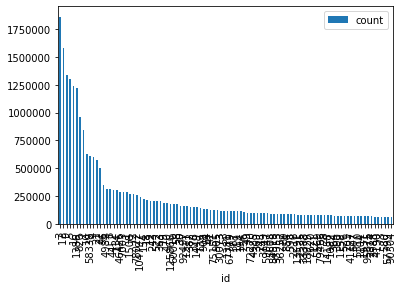

In [47]:
df_tags.plot(x='id', y='count', kind='bar')

In [50]:
df_tags

,id,tag_name,count,excerpt_post_id,wiki_post_id
0,3,javascript,1862833,3624960,3607052
1,17,java,1581854,3624966,3607018
2,9,c#,1339575,3624962,3607007
3,5,php,1303327,3624936,3607050
4,16,python,1236812,3624965,3607014
...,...,...,...,...,...
95,4190,numpy,63762,3736245,3736244
96,73,csv,63520,4913959,4913958
97,580,perl,63180,3625260,3607675
98,57799,symfony,63046,5692076,5692075


# Stackoverflow Posts

In [114]:
query = """SELECT
  *
FROM
  nlp_text_classification.stackoverflow_posts"""
df_posts = client.query(query).to_dataframe()

In [125]:
df_posts['tags_split'] = df_posts['tags'].str.split('|')

In [120]:
df_posts.tail()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,...,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count,tags_split
31008,23786052,How to disable the security setting on a Bixol...,<p>I currently have a need to disable the blue...,23791431.0,1.0,1,NaT,2014-05-21 14:23:18.787000+00:00,NaN,2014-05-21 18:47:41.913000+00:00,...,None,394913.0,None,394913.0,NaN,1,-1,ios|printing|bluetooth,249.0,"[ios, printing, bluetooth]"
31009,20146724,Coding a posterior distribution in R,<p>This may be a ridiculous question but I'm v...,NaN,1.0,0,NaT,2013-11-22 14:02:20.213000+00:00,NaN,2013-11-22 16:28:59.977000+00:00,...,None,163809.0,None,3018640.0,NaN,1,-1,r|bayesian,252.0,"[r, bayesian]"
31010,18960767,To find an element with nearest lower and grea...,<p>I have two sorted matrices A and B. For all...,NaN,1.0,2,NaT,2013-09-23 13:39:54.877000+00:00,NaN,2013-09-23 14:09:56.303000+00:00,...,None,NaN,None,2807424.0,NaN,1,-1,matlab|search,255.0,"[matlab, search]"
31011,10914269,prepareStatement() appears to be stripping sem...,<p>I am trying to execute a prepared statment ...,10915013.0,2.0,3,NaT,2012-06-06 12:30:11.113000+00:00,NaN,2012-06-06 13:38:19.650000+00:00,...,None,3431280.0,None,3431280.0,NaN,1,-1,java|prepared-statement,767.0,"[java, prepared-statement]"
31012,18092230,Cannot json dump a python dictionary with id key,<pre><code>json.dump({'id' : '3'}) File /Libra...,NaN,2.0,2,NaT,2013-08-06 23:32:30.133000+00:00,0.0,2013-08-07 00:04:55.913000+00:00,...,None,1014938.0,None,2658762.0,NaN,1,-1,python|json|dump,1791.0,"[python, json, dump]"


In [134]:
df_posts[df_posts['tags'].str.contains('python')]

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,...,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count,tags_split
7526,31890482,Seaborn - aesthetic options,<p>I'm plotting pandas data using a seaborn fa...,31900698.0,1.0,1,NaT,2015-08-08 06:48:19.930000+00:00,1.0,2015-08-09 15:46:01.113000+00:00,...,None,2605604.0,None,2605604.0,NaN,1,0,python|pandas|matplotlib|plot|seaborn,265.0,"[python, pandas, matplotlib, plot, seaborn]"
7552,19830737,Python from Coursera - For Loop with a little ...,<p>The question reads:</p> <blockquote> <p>Wri...,19830894.0,2.0,2,NaT,2013-11-07 08:06:46.440000+00:00,1.0,2014-10-23 13:26:19.520000+00:00,...,None,100297.0,None,2609312.0,NaN,1,0,python|loops|for-loop,1802.0,"[python, loops, for-loop]"
7574,37263298,Why does python unpack float act differently f...,<p>I don't understand why the following code g...,NaN,0.0,4,NaT,2016-05-16 21:09:14.693000+00:00,NaN,2016-05-16 21:09:14.693000+00:00,...,None,NaN,None,4389807.0,NaN,1,0,python-2.7,12.0,[python-2.7]
7642,27042400,Python how to slice a netcdf file.,<p>I am trying to slice a variable from a netc...,NaN,1.0,1,NaT,2014-11-20 14:45:21.913000+00:00,NaN,2014-11-25 16:45:59.907000+00:00,...,None,NaN,None,4274671.0,NaN,1,0,python|arrays|netcdf,270.0,"[python, arrays, netcdf]"
7721,35706638,Formatting floats so they all have the same to...,<p>I'm looking to format numbers so they alway...,NaN,0.0,4,NaT,2016-02-29 18:18:11.643000+00:00,0.0,2016-02-29 19:13:21.640000+00:00,...,None,NaN,None,5999035.0,NaN,1,0,python-2.7,17.0,[python-2.7]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30793,10012651,Optimum Python Environment setup on Windows......,<p>My friend was able to give me a hint on ins...,NaN,1.0,3,NaT,2012-04-04 13:58:58.427000+00:00,1.0,2014-06-23 14:15:55.220000+00:00,...,None,60724.0,None,1260520.0,NaN,1,-1,python|windows|virtualenv|sublimetext|bpython,321.0,"[python, windows, virtualenv, sublimetext, bpy..."
30859,32479163,Correctly shutting down subprocesses in Python,<p>I have a Python server that starts multiple...,NaN,1.0,6,NaT,2015-09-09 12:07:50.790000+00:00,NaN,2015-09-10 16:25:02.013000+00:00,...,None,4745643.0,None,4745643.0,NaN,1,-1,python|subprocess|signals,90.0,"[python, subprocess, signals]"
30907,29143838,How do I send commands to the ADB shell direct...,<p>I want to send commands in the ADB shell it...,NaN,2.0,0,NaT,2015-03-19 11:50:44.827000+00:00,NaN,2015-12-11 09:33:09.477000+00:00,...,None,NaN,None,4688913.0,NaN,1,-1,windows|shell|python-3.x|adb|popen,382.0,"[windows, shell, python-3.x, adb, popen]"
30990,14244195,colorbar with a slider using wxpython,<p>I haven't seen an example of this but I wan...,14260324.0,1.0,3,NaT,2013-01-09 18:41:35.587000+00:00,NaN,2013-01-10 14:37:12.067000+00:00,...,None,NaN,None,1750948.0,NaN,1,-1,python|slider|wxpython|color-mapping,222.0,"[python, slider, wxpython, color-mapping]"


In [144]:
def create_wordcloud(df: pd.DataFrame):
    posts = df[['body']].apply(lambda x: ' '.join(x), axis=0)[0]
    soup = BeautifulSoup(posts, 'html.parser')
    soup.get_text()
    
    stopwords = set(STOPWORDS)
    wordcloud_obj = WordCloud(stopwords=stopwords).generate(posts)
    
    return(wordcloud_obj)

In [145]:
temp_obj = create_wordcloud(df_posts)

TypeError: ('sequence item 340: expected str instance, NoneType found', 'occurred at index body')

In [143]:
df_posts[['body']].apply(lambda x: ' '.join(x), axis=0)[0]

TypeError: ('sequence item 340: expected str instance, NoneType found', 'occurred at index body')